In [2]:
# 일부만 할당된 GPU 메모리를 실행하는 동안 필요한만큼 늘릴 수 있도록 설정함
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [3]:
# 동일한 결과를 재현하기 위해서 random seed 고정
import numpy as np
np.random.seed(777)

In [4]:
# 모델 학습 시 불필요한 출력을 끄도록 함 (waning)

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

# 1. 데이터 준비

In [5]:
from tensorflow.keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

ValueError: Object arrays cannot be loaded when allow_pickle=False

In [6]:
from tensorflow.keras.datasets import imdb
import numpy as np

# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

# restore np.load for future normal usage
np.load = np_load_old

In [7]:
sample_idx = 4
print(train_data[sample_idx])

[1, 249, 1323, 7, 61, 113, 10, 10, 13, 1637, 14, 20, 56, 33, 2401, 18, 457, 88, 13, 2626, 1400, 45, 3171, 13, 70, 79, 49, 706, 919, 13, 16, 355, 340, 355, 1696, 96, 143, 4, 22, 32, 289, 7, 61, 369, 71, 2359, 5, 13, 16, 131, 2073, 249, 114, 249, 229, 249, 20, 13, 28, 126, 110, 13, 473, 8, 569, 61, 419, 56, 429, 6, 1513, 18, 35, 534, 95, 474, 570, 5, 25, 124, 138, 88, 12, 421, 1543, 52, 725, 6397, 61, 419, 11, 13, 1571, 15, 1543, 20, 11, 4, 2, 5, 296, 12, 3524, 5, 15, 421, 128, 74, 233, 334, 207, 126, 224, 12, 562, 298, 2167, 1272, 7, 2601, 5, 516, 988, 43, 8, 79, 120, 15, 595, 13, 784, 25, 3171, 18, 165, 170, 143, 19, 14, 5, 7224, 6, 226, 251, 7, 61, 113]


In [8]:
print(train_labels[sample_idx])

0


In [9]:
word_index = imdb.get_word_index() # 특정 단어를 하나의 정수 인덱스로 매핑해놓은 딕셔너리
reverse_word_index = dict([(v,k) for (k, v) in word_index.items()]) # {단어: 정수} => {정수: 단어}로 저장 

# 벡터화 된 문장을 텍스트로 디코딩
# 0, 1, 2번째 단어는 '패딩', '문서 시작', '사전에 없음'을 뜻하는 기호임
decoded_review = ' '.join([reverse_word_index.get(i-3,'?') for i in train_data[sample_idx]])
print(decoded_review)

? worst mistake of my life br br i picked this movie up at target for 5 because i figured hey it's sandler i can get some cheap laughs i was wrong completely wrong mid way through the film all three of my friends were asleep and i was still suffering worst plot worst script worst movie i have ever seen i wanted to hit my head up against a wall for an hour then i'd stop and you know why because it felt damn good upon bashing my head in i stuck that damn movie in the ? and watched it burn and that felt better than anything else i've ever done it took american psycho army of darkness and kill bill just to get over that crap i hate you sandler for actually going through with this and ruining a whole day of my life


# 2. 데이터 전처리

In [10]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension)) # 결과를 저장할 0 행렬 생성
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1 # 문장에 존재하는 단어들만 one-hot encoding
    return results

# 문장들을 일정한 크기의 벡터로 변환
X_train = vectorize_sequences(train_data)
X_test = vectorize_sequences(test_data)

In [11]:
# 리스트 형태인 레이블을 벡터로 변환
y_train = np.array(train_labels).astype('float32')
y_test = np.array(test_labels).astype('float32')

In [12]:
print(X_train[0])

[0. 1. 1. ... 0. 0. 0.]


In [13]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(25000, 10000)
(25000,)
(25000, 10000)
(25000,)


In [14]:
X_valid = X_train[:10000]
X_train = X_train[10000:]
y_valid = y_train[:10000]
y_train = y_train[10000:]

In [15]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(15000, 10000)
(15000,)
(10000, 10000)
(10000,)
(25000, 10000)
(25000,)


# 3. 네트워크 정의

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(10000,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# 4. 모델 컴파일

In [17]:
model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# 5. 모델 학습

In [18]:
history = model.fit(X_train, 
                    y_train,
                    epochs=20,
                    batch_size=256,
                    validation_data=(X_valid, y_valid))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 4s 235us/sample - loss: 0.4455 - acc: 0.8299 - val_loss: 0.3238 - val_acc: 0.8825
Epoch 2/20
15000/15000 [==============================] - 3s 180us/sample - loss: 0.2445 - acc: 0.9135 - val_loss: 0.2804 - val_acc: 0.8874
Epoch 3/20
15000/15000 [==============================] - 3s 180us/sample - loss: 0.1761 - acc: 0.9394 - val_loss: 0.2784 - val_acc: 0.8873
Epoch 4/20
15000/15000 [==============================] - 3s 196us/sample - loss: 0.1363 - acc: 0.9537 - val_loss: 0.3198 - val_acc: 0.8784
Epoch 5/20
15000/15000 [==============================] - 3s 193us/sample - loss: 0.1079 - acc: 0.9652 - val_loss: 0.3260 - val_acc: 0.8816
Epoch 6/20
15000/15000 [==============================] - 3s 193us/sample - loss: 0.0853 - acc: 0.9729 - val_loss: 0.3507 - val_acc: 0.8808
Epoch 7/20
15000/15000 [==============================] - 3s 194us/sample - loss: 0.0677 - acc: 0.9795 - val_l

# 6. 학습 과정 확인

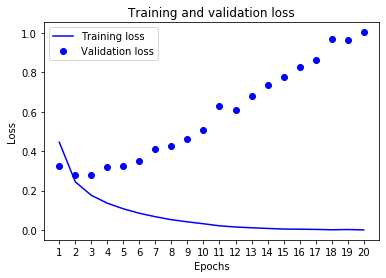

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'b', label='Training loss') # 'b'는 파란색 실선을 의미
plt.plot(epochs, val_loss, 'bo', label='Validation loss') # 'bo'는 파란색 점을 의미
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()

plt.show()

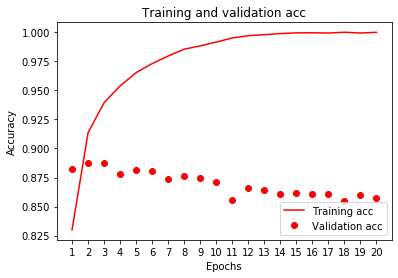

In [20]:
import matplotlib.pyplot as plt


acc, val_acc = history.history['acc'], history.history['val_acc']
epochs = range(1, len(loss)+1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'ro', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()

plt.show()

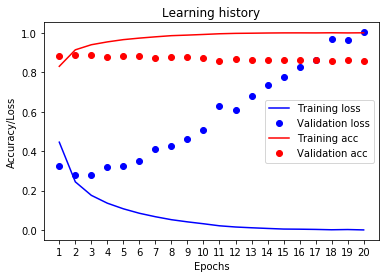

In [21]:
import matplotlib.pyplot as plt

loss, val_loss = history.history['loss'], history.history['val_loss']
acc, val_acc = history.history['acc'], history.history['val_acc']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'ro', label='Validation acc')
plt.title('Learning history')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.xticks(epochs)
plt.legend()

plt.show()

In [22]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test loss(20 epochs): ', test_loss)
print('test acc(20 epochs): ', test_acc)

25000/25000 [==============================] - 5s 189us/sample - loss: 1.1040 - acc: 0.8411
test loss(20 epochs):  1.104042431330681
test acc(20 epochs):  0.84108


# 7. (과대적합 되기 전까지) 모델 학습

In [23]:
# 기존 model 객체를 사용하면 이어서 학습되므로, 새로운 model 객체를 생성함
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(10000,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

history = model.fit(X_train, 
                    y_train,
                    epochs=3,
                    batch_size=256,
                    validation_data=(X_valid, y_valid))

Train on 15000 samples, validate on 10000 samples
Epoch 1/3
15000/15000 [==============================] - 3s 214us/sample - loss: 0.4437 - acc: 0.8250 - val_loss: 0.3299 - val_acc: 0.8777
Epoch 2/3
15000/15000 [==============================] - 3s 191us/sample - loss: 0.2465 - acc: 0.9142 - val_loss: 0.2746 - val_acc: 0.8877
Epoch 3/3
15000/15000 [==============================] - 3s 180us/sample - loss: 0.1775 - acc: 0.9391 - val_loss: 0.2985 - val_acc: 0.8803


In [24]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test loss(3 epochs): ', test_loss)
print('test acc(3 epochs): ', test_acc)

25000/25000 [==============================] - 4s 164us/sample - loss: 0.3247 - acc: 0.8683
test loss(3 epochs):  0.32468896041870116
test acc(3 epochs):  0.86832


# 8. 학습된 모델로 새로운 데이터 예측

In [25]:
# 여러 개 동시에 예측
result = model.predict(X_test)
print(result)

print()

# 하나씩 개 동시에 예측
sample = X_test[0]
result = model.predict(np.expand_dims(sample, axis=0))
print(result)

[[0.22035843]
 [0.99870247]
 [0.66444325]
 ...
 [0.06152377]
 [0.05333686]
 [0.37609476]]

[[0.2203584]]
